(example_4)=
# Example 4: Learning causal coupling

Author contribution: Lina Walkowiak

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark



In [2]:
%load_ext autoreload
%autoreload 2

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import jit, vjp
from jax.tree_util import Partial
from pyhgf import load_data
from pyhgf.math import binary_surprise
from pyhgf.model.network import Network
from pyhgf.utils import beliefs_propagation
from pyhgf.typing import AdjacencyLists
from pytensor.graph import Apply, Op
from pyhgf.updates.causal_functions import calculate_mutual_information, calculate_surd, calculate_prediction_difference, get_coupling_strength, update_coupling_strength_prediction_error, update_coupling_strength_surd, set_coupling_strength, edge_update
from pyhgf.response import first_level_gaussian_surprise


np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Introduction
In this notebook, we implement a model that incorporates causal coupling. 
First, the theory of the causal couplign mechanisms will be outlined before then implementing the functions on simulated data. We simulate two time series, where one has a causal influence on the other, differeing in its strength. The model then takes two time series as input, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 



##  Methods for Updating of Causal Coupling

### Mutual Information and SURD Decomposition

Using mutual information (MI), we quantify the shared information between nodes:
   - Parent-Child MI: $$ I(\text{Parent}; \text{Child}) = H(\text{Parent}) + H(\text{Child}) - H(\text{Parent}, \text{Child}) $$
   - Parent-Parent MI: Similarly, it represents the shared information between parents.
   - Self Entropy: $ H(\text{Child}) $, representing the child's uncertainty.

We then decompose MI into SURD terms:
   - Redundant: Shared information across parents.
   - Unique: Exclusive information from each parent.
   - Synergistic: Joint contribution when parents are considered together. (currently, it is considering all parents, not indidvidual pairs.)
   - Leak: Remaining uncertainty in the child.

The coupling strength is then updated based on the parent's components constituation. 
Weighted Scoring: Each type of information is assigned a weight, with unique and synergistic information increasing the coupling, while redundant decreases it (what about leak?)

A sigmoid function is used for more a smooth of a adjustment to the coupling strength. The coupling is then clipped to stay within [0,1].




### Sigmoid-Adjusted Prediction Difference

This method updates coupling strengths by assessing the difference in PE between parent and child.
- Prediction Difference:
$$ \Delta \text{PE} = \text{PE}_{\text{child}} - (\text{coupling strength} \times \text{PE}_{\text{parent}}) 
   $$
- Reliability Adjustment: Using a sigmoid function, the adjustment factor is calculated as:
$$
\text{Adjustment} = \frac{\eta}{1 + e^{-(\frac{\Delta \text{PE}}{\text{PE}_{\text{child}} + 1e-8} - 1)}}
$$
- Updated Coupling Strength: Coupling is updated and clipped within [0, 1].

This works on the logic that only reliable parents' influences should lead to strengthened coupling, while unreliable influences weaken it.

## Simulating a data set


We create two synthetic time series, x1 and x2, where x1 is an independent random walk and x2 depends on x1 with three varying levels of influence: strong, medium, and low. This approach allows us to model a dynamic causal relationship between the series, with dependency strengths changing in teh three different phases. We add noise to each phase, with the noise level increasing and thereby the dependency weakens. 

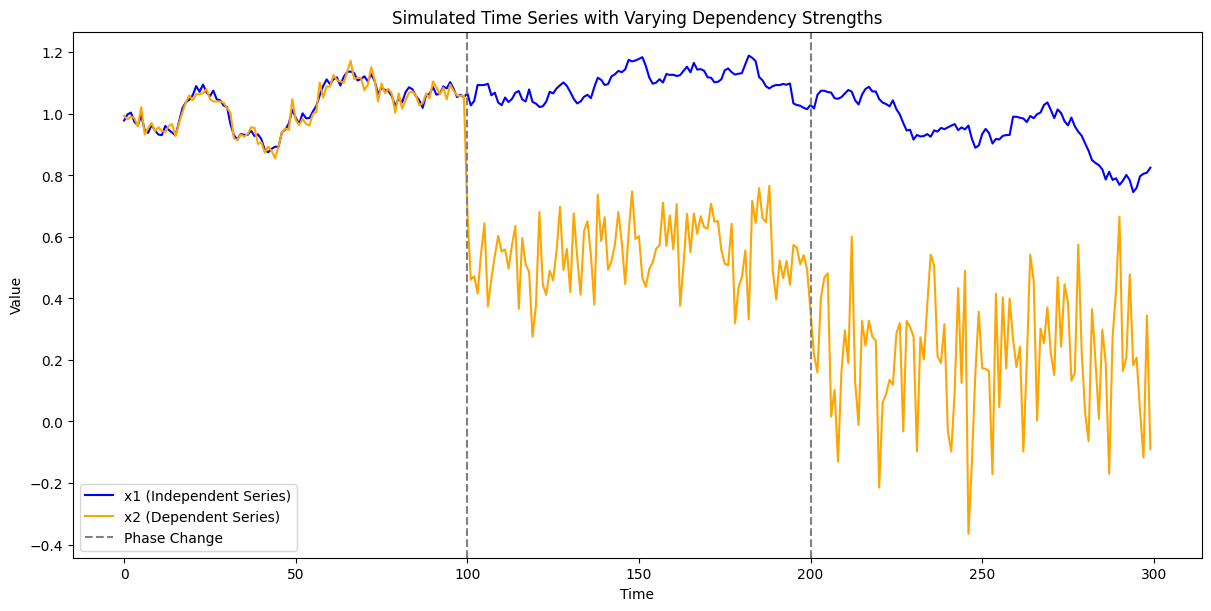

In [3]:

# Parameters
n_points_per_phase = 100
noise_level_strong = 0.02
noise_level_medium = 0.1
noise_level_low = 0.2

# Generate first series as a random walk
x1 = np.cumsum(np.random.normal(0, 0.02, 3 * n_points_per_phase)) + 1

# Generate x_2 based on x_1 with varying levels of dependency
x2 = np.zeros_like(x1)

# Strong dependency
x2[:n_points_per_phase] = x1[:n_points_per_phase] + np.random.normal(0, noise_level_strong, n_points_per_phase)

# Medium
x2[n_points_per_phase:2 * n_points_per_phase] = (
    0.5 * x1[n_points_per_phase:2 * n_points_per_phase]
    + np.random.normal(0, noise_level_medium, n_points_per_phase)
)

# Low 
x2[2 * n_points_per_phase:] = (
    0.2 * x1[2 * n_points_per_phase:] 
    + np.random.normal(0, noise_level_low, n_points_per_phase)
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x1, label='x1 (Independent Series)', color='blue')
plt.plot(x2, label='x2 (Dependent Series)', color='orange')
plt.axvline(n_points_per_phase, color='gray', linestyle='--', label='Phase Change')
plt.axvline(2 * n_points_per_phase, color='gray', linestyle='--')
plt.title('Simulated Time Series with Varying Dependency Strengths')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

#### HGF model (constant coupling)

Here, we initialize two separate HGF models for x1 and x2. 
Each model independently infers over its assigned time series. 

array([<Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>,
       <Axes: >], dtype=object)

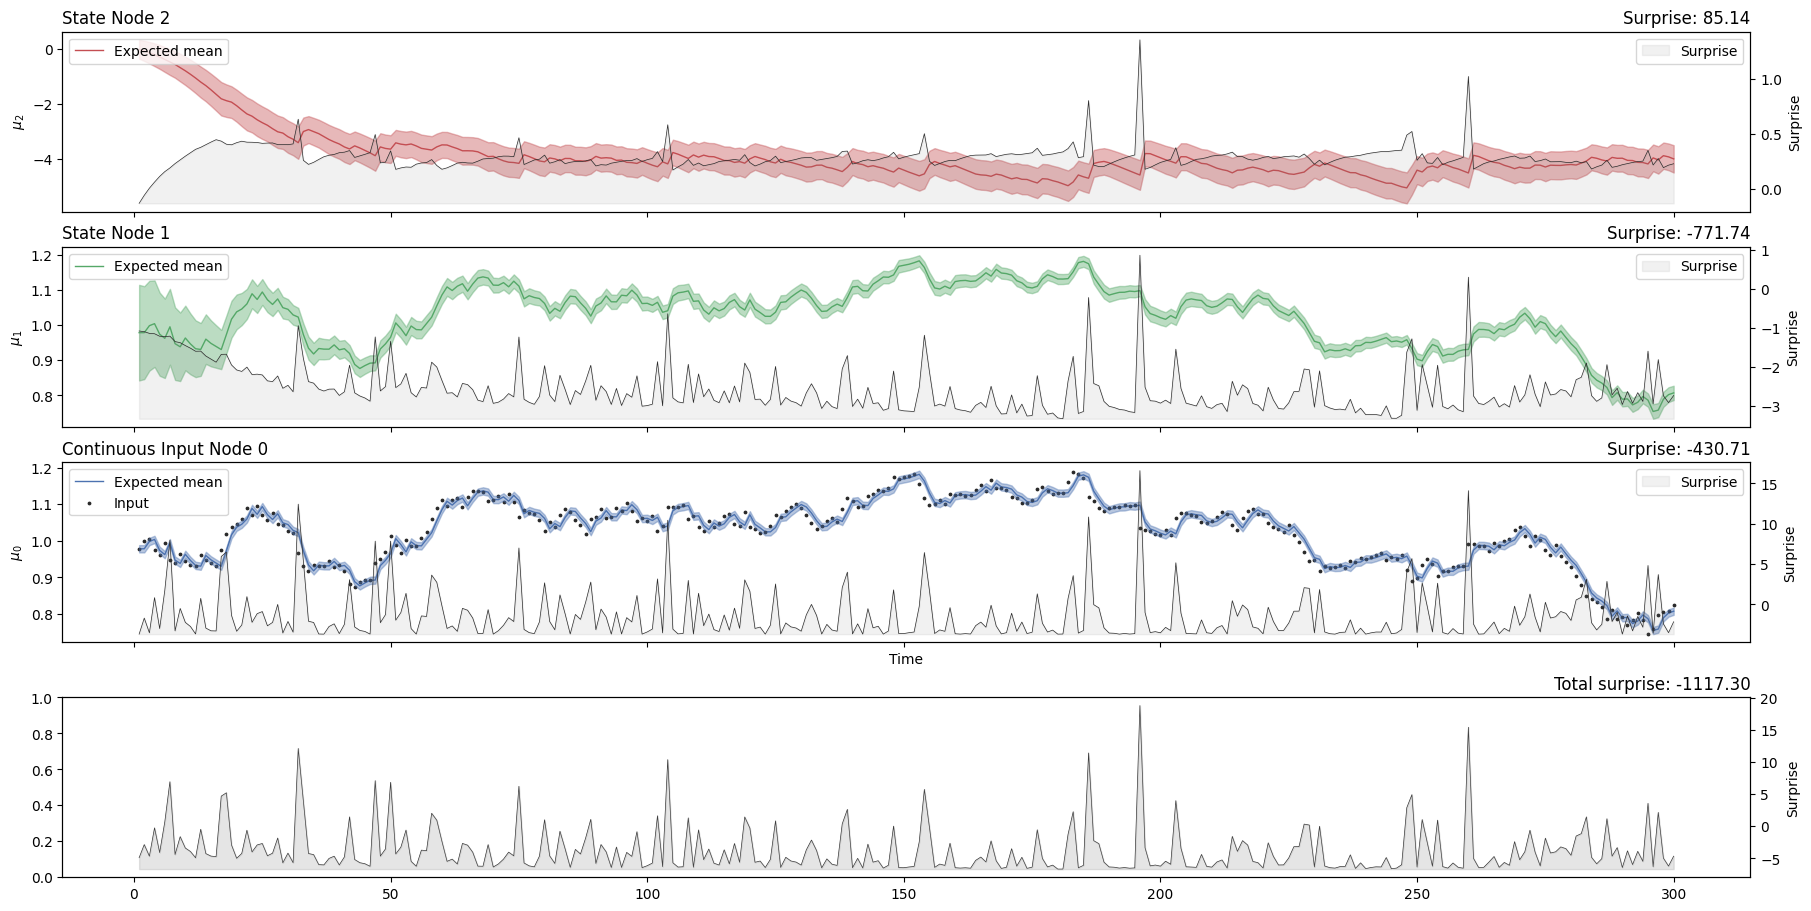

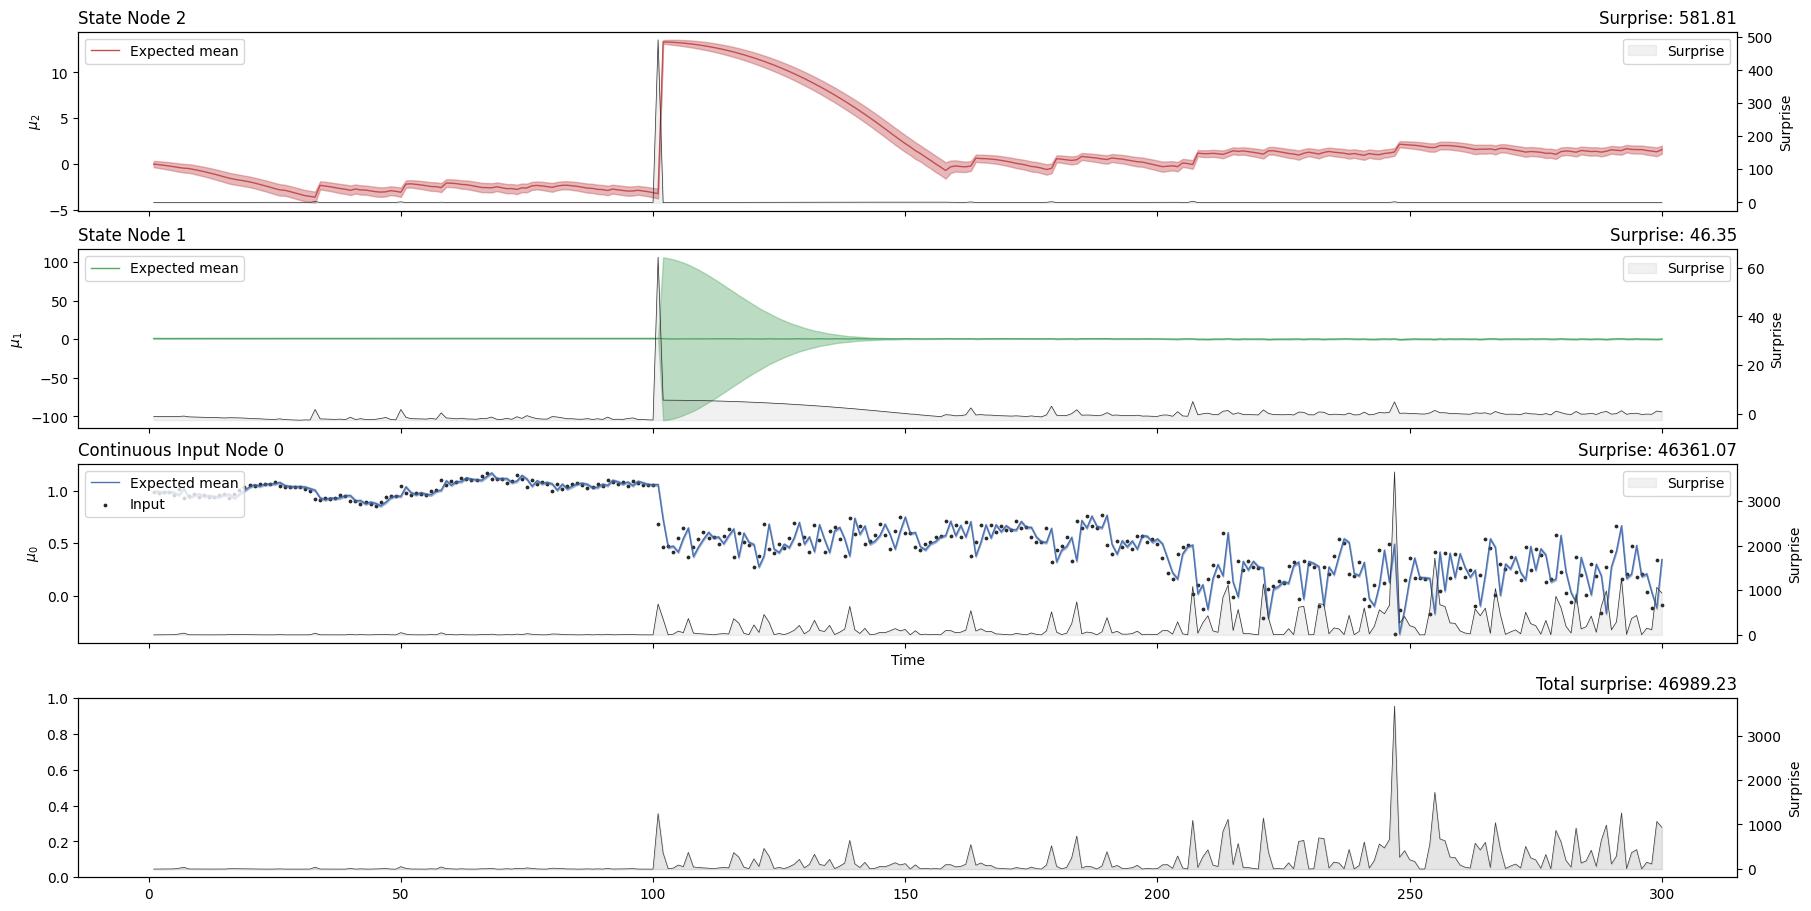

In [4]:
# Initialize two independent HGFs for X1 and X2
hgf_X1 = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=x1[0], value_children=0)
    .add_nodes(precision=1e1, volatility_children=1)
)
hgf_X2 = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=x2[0], value_children=0)
    .add_nodes(precision=1e1, volatility_children=1)
)

# Input the time series data to each model
hgf_X1 = hgf_X1.input_data(input_data=x1)
hgf_X2 = hgf_X2.input_data(input_data=x2)

# Plot trajectories for each HGF
hgf_X1.plot_trajectories(show_total_surprise=True)
hgf_X2.plot_trajectories(show_total_surprise=True)


## Causal coupling model

In this section, we create a coupled HGF model to capture the causal influence of x1 on x2. This setup should include directed connections from x1 to x2 so that the model can learn the strength of causal influence between the two series. The HGF should therefore dynamically adapt to the varying dependency strengths across phases, investigating whether it can detect and quantify the causal effect and adapt the overall predictions. The coupled HGF’s performance can then be compared to that of the independent models to evaluate the added value of causal coupling in the models' performances. 

In [5]:
# Initialize a coupled HGF for X2 with X1 as an influencing node
coupled_hgf = (
    Network()
    .add_nodes(precision=1e4)  # X1 node
    .add_nodes(precision=1e4, value_children=0) # first parent
    .add_nodes(precision=1e1, volatility_children=1) # volatility parent
    .add_nodes(precision=1e4, value_children=0) # here, we would like causal coupling
    .add_nodes(precision=1e4, value_children= 3)   # this should be another input node getting x_2 
    .add_nodes(precision=1e1, volatility_children=4) 
)

coupled_hgf.plot_network

# Input the time series data to the coupled HGF
# 
# Plot trajectories for the coupled HGF



<bound method Network.plot_network of <pyhgf.model.network.Network object at 0x142edc140>>

### Testing functions
- Mutual information of child node and parents
- SURD values of child and parent
- approximate 'counterfactual' prediction error without parent's influence
- updated prediction error based on learning rate 


In [6]:
MI_dict = calculate_mutual_information(hgf_X1, child_idx = 0)
SURD = calculate_surd(MI_dict, 0)
update_coupling_strength_surd(hgf_X1, 0)



TypeError: update_coupling_strength_surd() missing 1 required positional argument: 'parent_idx'

In [ ]:
# Exmaple of PE function usage
counterfactual_error = calculate_prediction_difference(
    hgf_X1, child_idx = 0
)
# And Upadate strength based on PE
updated_strength = update_coupling_strength_prediction_error(
    hgf_X1, child_idx=0, learning_rate = 0.05
)


In [ ]:
# Set a new coupling strength between child node 1 and parent node 2
float = get_coupling_strength(hgf_X1, child_idx=0, parent_idx=1)
float

1.0

In [7]:
edge_update(network=hgf_X1, child_idx=0, parent_idx=1,  method='prediction_error', learning_rate=0.1)

1.0

## System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Nov 12 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

pyhgf     : 0.0.0
matplotlib: 3.9.2
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
seaborn   : 0.13.2
arviz     : 0.20.0
pandas    : 2.2.3
pymc      : 5.17.0
IPython   : 8.29.0
pytensor  : 2.25.5
numpy     : 1.26.0
jax       : 0.4.35

Watermark: 2.5.0

